In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from random import randint, uniform, gauss
import math

In [34]:
C_train = 60000
alpha = 0.37
error_all = 0.5

X_train = []
y_train = []
for i in range(C_train):
    xi = uniform(0, 3)
    sigmai = uniform(0.1, 2)
    error_now = abs(gauss(0, error_all))

    xi1 = math.exp(alpha * xi)
    sigmai1 = ((alpha * xi1) ** 2 * sigmai ** 2 + error_now ** 2) ** 0.5
    X_train.append([xi, sigmai ** 2])
    y_train.append([xi1, sigmai1 ** 2])

X_train = torch.tensor(X_train).view(-1, 2)
y_train = torch.tensor(y_train).view(-1, 2)

In [35]:
backbone = nn.Sequential(nn.Linear(2, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU())

head_x = nn.Linear(32, 1)
head_sigma = nn.Linear(32, 1)
softplus = nn.Softplus()

params = list(backbone.parameters()) + list(head_x.parameters()) + list(head_sigma.parameters())
opt = optim.Adam(params, lr=10**(-3))

In [36]:
batch = 1024
epochs = 50

for k in range(epochs):
    pos = torch.randperm(X_train.size(0))
    ans = 0
    cnt = 0
    for i in range(0, X_train.size(0), batch):
        ind = pos[i:i + batch]
        x_now = X_train[ind]
        y_now = y_train[ind]

        res = backbone(x_now)
        x = head_x(res)

        sigma = softplus(head_sigma(res))
        x_ok = y_now[:, [0]]
        sigma_ok = y_now[:, [1]]
        loss = ((x - x_ok) ** 2).mean() + ((sigma - sigma_ok) ** 2).mean()

        opt.zero_grad()
        loss.backward()
        opt.step()
        ans += loss.item()
        cnt += 1
    print("iter ", k + 1, ", loss = ", ans / cnt, sep='')

iter 1, loss = 2.0998095546738575
iter 2, loss = 0.5596207779342846
iter 3, loss = 0.3078476104695918
iter 4, loss = 0.18281893533165172
iter 5, loss = 0.1490822612481602
iter 6, loss = 0.1436466232447301
iter 7, loss = 0.14109368887493165
iter 8, loss = 0.13848768162020184
iter 9, loss = 0.13546457053241084
iter 10, loss = 0.13357089977648298
iter 11, loss = 0.13214233176688017
iter 12, loss = 0.13104609513686874
iter 13, loss = 0.1299385409486496
iter 14, loss = 0.12895259639974369
iter 15, loss = 0.12836709479659292
iter 16, loss = 0.1282373510174832
iter 17, loss = 0.1276305335558067
iter 18, loss = 0.12736637700917358
iter 19, loss = 0.12709310676081706
iter 20, loss = 0.12671582615476543
iter 21, loss = 0.12670936864816537
iter 22, loss = 0.12641176189911568
iter 23, loss = 0.12633963320719993
iter 24, loss = 0.126108519227828
iter 25, loss = 0.12635331133664665
iter 26, loss = 0.12597584875963502
iter 27, loss = 0.12609899145061687
iter 28, loss = 0.12576519937838537
iter 29, lo

In [37]:
C_test = 10000
X_test = []
y_test = []
for i in range(C_test):
    xi = uniform(0, 3)
    sigmai = uniform(0.1, 2)
    error_now = abs(gauss(0, error_all))

    xi1 = math.exp(alpha * xi)
    sigmai1 = ((alpha * xi1) ** 2 * sigmai ** 2 + error_now ** 2) ** 0.5
    X_test.append([xi, sigmai ** 2])
    y_test.append([xi1, sigmai1 ** 2])

X_test = torch.tensor(X_test).view(-1, 2)
y_test = torch.tensor(y_test).view(-1, 2)
mse_error = 0
mse_x = 0
for i in range(C_test):
    h = backbone(X_test[i])
    xi1 = head_x(h)
    sigmai1 = softplus(head_sigma(h))
    mse_error += (y_test[i][1] - sigmai1) ** 2
    mse_x += (y_test[i][0] - xi1) ** 2

mse_error /= C_test
mse_x /= C_test
print("MSE sigma =", mse_error.item())
print("MSE x = ", mse_x.item())

MSE sigma = 0.12947264313697815
MSE x =  0.00014148435730021447


In [38]:
import numpy as np
import matplotlib.pyplot as plt

C_iter = 30
col_test = 1000

need_x = [0.0] * (C_iter + 1)
need_sigma = [0.0] * (C_iter + 1)
res_x  = [0.0] * (C_iter + 1)
res_sigma = [0.0] * (C_iter + 1)

sum_error_x = [0] * (C_iter + 1)
sum_error_sigma = [0] * (C_iter + 1)

for iter1 in range(col_test):
    x0 = uniform(0, 1.5)
    sigma0 = uniform(0.2, 1)

    x = torch.tensor([[x0]], dtype=torch.float32)
    sigma = torch.tensor([[sigma0 ** 2]], dtype=torch.float32)
    x_true = torch.tensor([[x0]], dtype=torch.float32)
    sigma_true = torch.tensor([[sigma0 ** 2]], dtype=torch.float32)

    need_x[0] += x0
    need_sigma[0] += sigma0**2
    res_x[0] += x0
    res_sigma[0] += sigma0**2

    for i in range(C_iter):
        error_now = error_all ** 2
        xii1 = torch.exp(alpha * x_true)
        sigmai1 = ((alpha * xii1)**2) * sigma_true + error_now
        need_x[i + 1] += xii1.item()
        need_sigma[i + 1] += sigmai1.item()
        x_true = xii1
        sigma_true = sigmai1

        now = torch.cat([x, sigma], dim=1)
        h = backbone(now)
        x = softplus(head_x(h))
        sigma = softplus(head_sigma(h))
        res_x[i + 1] += x.item()
        res_sigma[i + 1] += sigma.item()

        sum_error_x[i + 1] += (x_true.item() - x.item()) ** 2
        sum_error_sigma[i + 1] += (sigma_true.item() - sigma.item()) ** 2

for i in range(C_iter + 1):
    need_x[i] /= col_test
    need_sigma[i] /= col_test
    res_x[i] /= col_test
    res_sigma[i] /= col_test

    sum_error_x[i] /= col_test
    sum_error_sigma[i] /= col_test

need_x = np.array(need_x)
need_sigma = np.sqrt(np.array(need_sigma))
res_x = np.array(res_x)
res_sigma = np.sqrt(np.array(res_sigma))

sum_error_x = np.array(sum_error_x)
sum_error_sigma = np.array(sum_error_sigma)
print(sum_error_sigma)

[0.00000000e+00 1.06188016e-04 4.39388977e-04 5.66664816e-03
 1.99674354e-02 3.69332435e-02 6.15878018e-02 1.02532066e-01
 1.75927741e-01 3.32733802e-01 6.64134154e-01 1.30463184e+00
 2.63758747e+00 5.36708842e+00 1.04285292e+01 1.60459438e+01
 1.87643738e+01 2.20215464e+01 2.63191916e+01 3.20462017e+01
 3.97705384e+01 5.03127170e+01 6.48642107e+01 8.51609168e+01
 1.13737262e+02 1.54298379e+02 2.12265978e+02 2.95580222e+02
 4.15878669e+02 5.90228010e+02 8.43663567e+02]


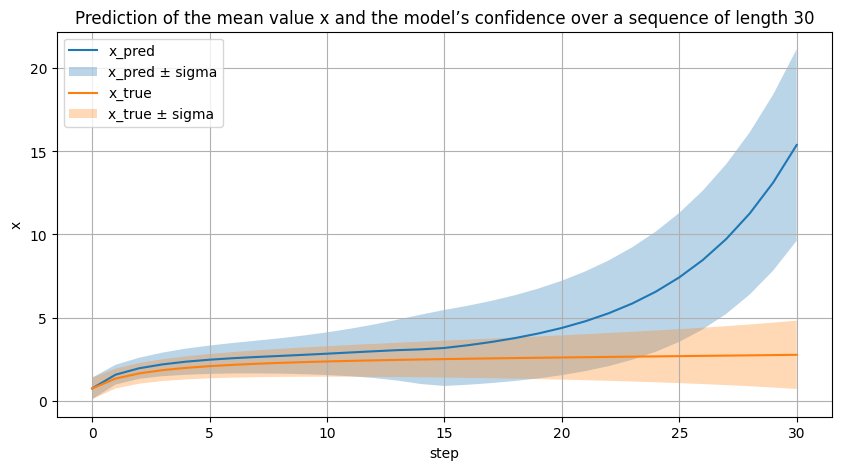

In [39]:
need_x = np.array(need_x)
need_sigma = np.array(need_sigma)
res_x = np.array(res_x)
res_sigma = np.array(res_sigma)
steps = np.array(list(range(C_iter + 1)))
plt.figure(figsize=(10, 5))
plt.xlabel("step")
plt.title("Prediction of the mean value x and the model’s confidence over a sequence of length 30")
plt.ylabel("x")
plt.plot(steps, res_x, label = "x_pred")
plt.fill_between(steps, res_x - res_sigma, res_x + res_sigma, alpha=0.3, label = "x_pred ± sigma")
plt.plot(steps, need_x, label = "x_true")
plt.fill_between(steps, need_x - need_sigma, need_x + need_sigma, alpha=0.3, label = "x_true ± sigma")
plt.grid()
plt.legend()
plt.show()

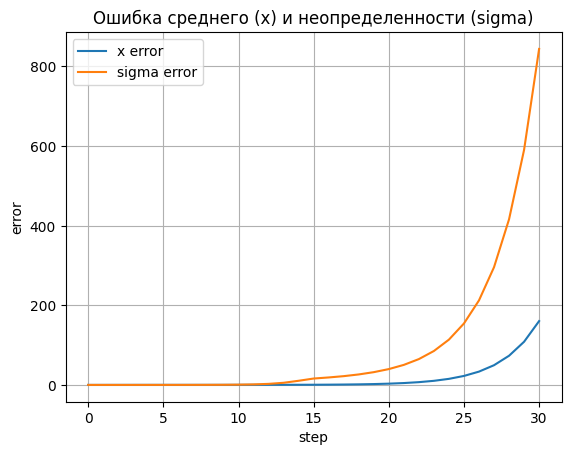

In [40]:
steps = np.array(list(range(C_iter + 1)))
plt.xlabel("step")
plt.ylabel("error")
plt.title("Ошибка среднего (x) и неопределенности (sigma)")
plt.plot(steps, sum_error_x, label="x error")
plt.plot(steps, sum_error_sigma, label="sigma error")
plt.grid()
plt.legend()
plt.show()